In [1]:
pip install xgboost lightgbm catboost wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [3]:
file_path='data/Dataset_new.xlsx'
data=pd.read_excel(file_path)
data.head()
columns_to_drop = [ 'Unnamed: 10',
 'Unnamed: 11']  # replace with your actual column names
# Drop the specified columns
data = data.drop(columns=columns_to_drop)
data.columns.tolist()

['Paper Link',
 'Year',
 'Composition',
 'A_site',
 'B_site',
 'Temperature(K)',
 'Electrical Conductivity, σ(S/cm)',
 'Thermal conductivity, κ(W/(m-K))',
 'Seeback Coefficient, S(μV/K)',
 'ZT']

In [4]:
data.describe()

,Year,Temperature(K),"Electrical Conductivity, σ(S/cm)","Thermal conductivity, κ(W/(m-K))","Seeback Coefficient, S(μV/K)",ZT
count,1893.000000,1892.000000,1828.000000,1258.000000,1614.000000,1011.000000
mean,2013.042261,630.919067,1236.951474,3.105510,-70.390051,0.052834
std,7.323924,267.524335,3562.669980,5.037916,201.498911,0.055857
min,1993.000000,12.000000,0.000000,0.001198,-1068.424556,0.000000
25%,2009.000000,423.750000,14.982394,1.612015,-160.954969,0.014810
50%,2013.000000,629.000000,91.380685,2.131481,-103.125628,0.038244
75%,2017.000000,835.000000,514.883054,2.870883,6.850007,0.070948
max,2024.000000,1280.000000,35682.623370,35.611473,1054.523488,0.407208


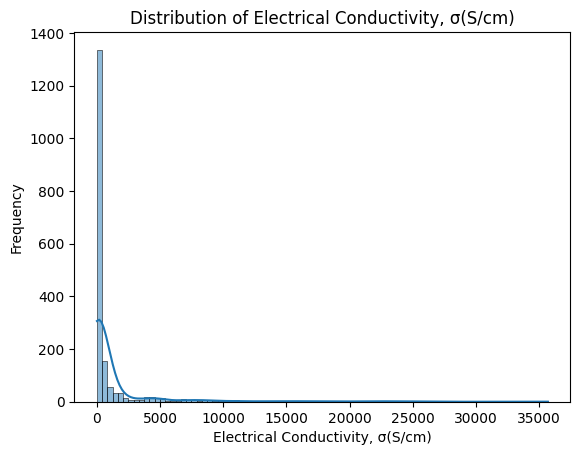

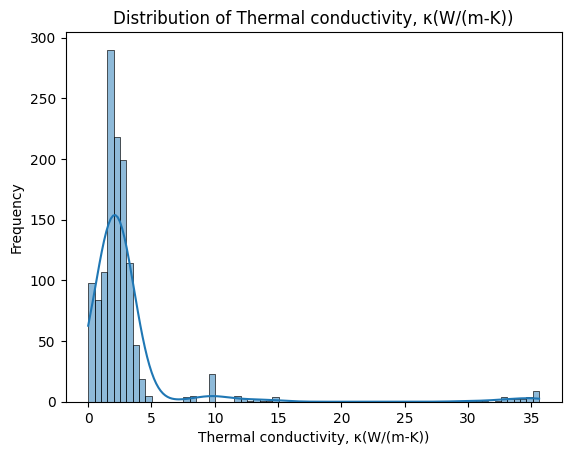

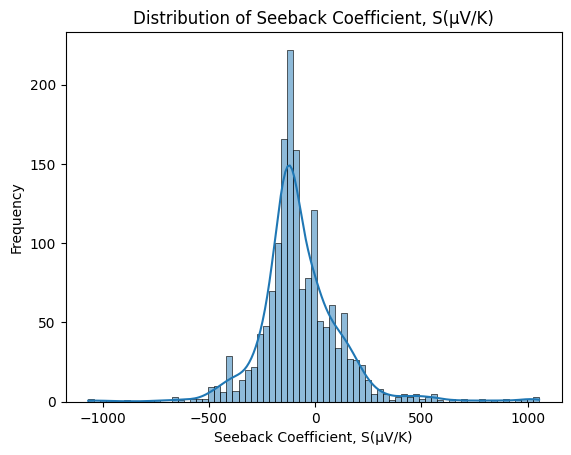

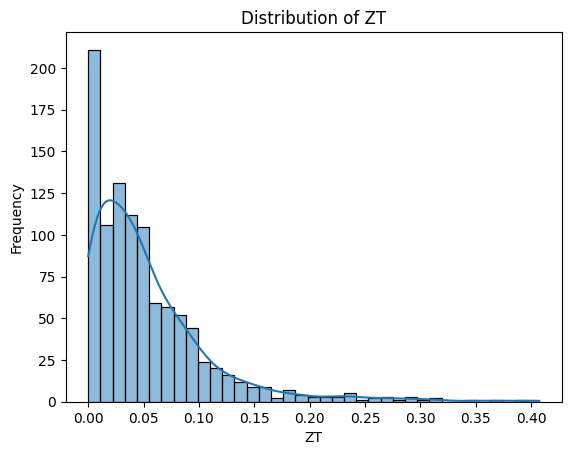

In [5]:
columns_to_plot = [ 
    'Electrical Conductivity, σ(S/cm)',
    'Thermal conductivity, κ(W/(m-K))',
    'Seeback Coefficient, S(μV/K)',
    'ZT'
]
for col in columns_to_plot:
    plt.figure()
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [6]:
# Specify the column you are interested in
column_of_interest = 'Composition'  # replace with your actual column name
# Get unique values and their count
unique_values = data[column_of_interest].unique()
number_of_unique_values = data[column_of_interest].nunique()
print(f"Column: {column_of_interest}")
print(f"Number of unique values: {number_of_unique_values}")
print(f"Unique values: {unique_values}")

Column: Composition
Number of unique values: 110
Unique values: ['Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3' nan 'Ca0.25Sr0.25Ba0.25Nd0.25TiO3'
 'Ca0.25Sr0.25Ba0.25Sm0.25TiO3' 'Ca0.25Sr0.25Ba0.25Gd0.25TiO3'
 'Ca0.25Sr0.25Ba0.25Dy0.25TiO3' 'Ca0.25Sr0.25Ba0.25Ho0.25TiO3'
 'Ca0.25Sr0.25Ba0.25Eu0.25TiO3' 'Ca0.33Sr0.33Ba0.33Ti0.45Zr0.45Nb0.1O3'
 'Ca0.33Sr0.33Ba0.33Ti0.4Zr0.4Nb0.2O3'
 'Ca0.33Sr0.33Ba0.33Ti0.33Zr0.33Nb0.33O3' 'La0.9Sr0.1CoO3'
 'Pr0.9Sr0.1MnO3' ' Pr0.9Sr0.1FeO3' 'Ca0.2Sr0.2Ba0.2La0.2Pb0.2TiO3'
 'NaWO3' 'KWO3' 'Sr0.9La0.1Zr0.25Sn0.25Ti0.25Hf0.25O3'
 ' Ca0.25Sr0.25Ba0.25La0.25TiO3' 'Ca0.25Sr0.25Ba0.25Ce0.25TiO3' 'CaTiO3'
 'La0.1Ca0.9TiO3' 'La0.15Ca0.85TiO3' 'La0.2Ca0.8TiO3' 'La0.25Ca0.75TiO3'
 'Pr0.8Sr0.2MnO3' 'CaMnO3' 'Ca0.9Bi0.1MnO3' 'Pr0.9Sr0.1FeO3'
 'Ca0.98Er0.02MnO3' 'Ca0.96Er0.02La0.02MnO3' 'Ca0.96Er0.02Sm0.02MnO3'
 'Ca0.96Er0.02Yb0.02MnO3' 'La0.075Sm0.075Sr0.85TiO3-ẟ'
 'CaMn0.06Nb0.02Ta0.02O3' 'EuTiO3' 'EuTi0.98Nb0.02O3'
 'Ca0.9Yb0.1Mn0.98Nb0.02O3' 'Ca0.25Cu0.75IrO3' 'Ca0.9Y0.1Mn0.9F

In [7]:
# Specify the column you are interested in
column_of_interest = 'A_site'  # replace with your actual column name

# Function to split text by numeric values and remove numeric values
def split_and_remove_numbers(text):
    # Split by commas first
    parts = [part.strip() for part in text.split(',')]
    # Split each part by numeric values and remove any empty strings
    parts = [subpart for part in parts for subpart in re.split(r'\d+', part) if subpart]
    return parts


# Apply the function to the column and get unique values
all_texts = data[column_of_interest].dropna().apply(lambda x: split_and_remove_numbers(str(x)))

# Flatten the list of lists and get unique values

unique_A_site = pd.Series([item for sublist in all_texts for item in sublist]).unique()
# Count the number of unique values
num_unique_texts = len(unique_A_site)

print(f"Total number of unique A site candidates in column '{column_of_interest}': {num_unique_texts}")

print(f"Unique A site candidates '{column_of_interest}' after removing numeric values:")
print(unique_A_site)
# Specify the column you are interested in
column_of_interest = 'B_site'  # replace with your actual column name

# Function to split text by numeric values and remove numeric values
def split_and_remove_numbers(text):
    # Split by commas first
    parts = [part.strip() for part in text.split(',')]
    # Split each part by numeric values and remove any empty strings
    parts = [subpart for part in parts for subpart in re.split(r'\d+', part) if subpart]
    return parts


# Apply the function to the column and get unique values
all_texts = data[column_of_interest].dropna().apply(lambda x: split_and_remove_numbers(str(x)))

# Flatten the list of lists and get unique values
unique_B_site = pd.Series([item for sublist in all_texts for item in sublist]).unique()

# Count the number of unique values
num_unique_texts = len(unique_B_site)

print(f"Total number of unique B site candidates in column '{column_of_interest}': {num_unique_texts}")

print(f"Unique B site candidates '{column_of_interest}' after removing numeric values:")
print(unique_B_site)


Total number of unique A site candidates in column 'A_site': 22
Unique A site candidates 'A_site' after removing numeric values:
['Ca' 'Sr' 'Ba' 'Pb' 'La' 'Nd' 'Sm' 'Gd' 'Dy' 'Ho' 'Eu' 'Pr' 'Na' 'K' 'Ce'
 'Bi' 'Er' 'Yb' 'Cu' 'Y' 'In' 'Sb']
Total number of unique B site candidates in column 'B_site': 16
Unique B site candidates 'B_site' after removing numeric values:
['Ti' 'Zr' 'Nb' 'Co' 'Mn' 'Fe' 'W' 'Sn' 'Hf' 'Ta' 'Ir' 'Mo' 'Ni' 'Ru' 'Rh'
 'Cr']


In [8]:
# Convert lists to sets
set_A = set(unique_A_site)
set_B = set(unique_B_site)

# Find common elements
common_elements = set_A.intersection(set_B)

# Convert set back to list if needed
common_elements_list = list(common_elements)

# Print or use the common elements
print("Common elements:", common_elements_list)

Common elements: []


In [9]:
import re
import pandas as pd

# Helper function: split into elements, drop numbers
def split_and_remove_numbers(text):
    parts = [part.strip() for part in text.split(',')]
    parts = [subpart for part in parts for subpart in re.split(r'\d+', part) if subpart]
    return parts

# -------------------------
# Deduplicate compositions
# -------------------------
# Assuming your full composition is in a column called "Composition"
# If not, replace with the correct identifier column
unique_data = data.drop_duplicates(subset=['Composition'])

# -------------------------
# A-site
# -------------------------
column_of_interest = 'A_site'

# Extract all A-site entries without numbers (only from unique compositions)
all_texts_A = unique_data[column_of_interest].dropna().apply(lambda x: split_and_remove_numbers(str(x)))

# Flatten and get unique A-site elements
unique_A_site = pd.Series([item for sublist in all_texts_A for item in sublist]).unique()

# Count frequency of each A-site element in unique compositions
freq_A_site = pd.Series([item for sublist in all_texts_A for item in sublist]).value_counts()

print(f"Total number of unique A site candidates: {len(unique_A_site)}")
print("Unique A site candidates:")
print(unique_A_site)
print("\nFrequency of A site candidates:")
print(freq_A_site)

# -------------------------
# B-site
# -------------------------
column_of_interest = 'B_site'

# Extract all B-site entries without numbers (only from unique compositions)
all_texts_B = unique_data[column_of_interest].dropna().apply(lambda x: split_and_remove_numbers(str(x)))

# Flatten and get unique B-site elements
unique_B_site = pd.Series([item for sublist in all_texts_B for item in sublist]).unique()

# Count frequency of each B-site element in unique compositions
freq_B_site = pd.Series([item for sublist in all_texts_B for item in sublist]).value_counts()

print(f"\nTotal number of unique B site candidates: {len(unique_B_site)}")
print("Unique B site candidates:")
print(unique_B_site)
print("\nFrequency of B site candidates:")
print(freq_B_site)


Total number of unique A site candidates: 22
Unique A site candidates:
['Ca' 'Sr' 'Ba' 'Pb' 'La' 'Nd' 'Sm' 'Gd' 'Dy' 'Ho' 'Eu' 'Pr' 'Na' 'K' 'Ce'
 'Bi' 'Er' 'Yb' 'Cu' 'Y' 'In' 'Sb']

Frequency of A site candidates:
Ca    63
Sr    40
La    25
Ba    22
Sm    10
Yb     9
Y      8
Nd     7
Pr     6
Gd     5
Eu     4
Er     4
Pb     3
Dy     3
Ce     2
K      1
Ho     1
Na     1
Bi     1
Cu     1
In     1
Sb     1
Name: count, dtype: int64

Total number of unique B site candidates: 16
Unique B site candidates:
['Ti' 'Zr' 'Nb' 'Co' 'Mn' 'Fe' 'W' 'Sn' 'Hf' 'Ta' 'Ir' 'Mo' 'Ni' 'Ru' 'Rh'
 'Cr']

Frequency of B site candidates:
Mn    43
Ti    27
Co    24
Fe    19
Nb    12
Mo    11
W      7
Ni     6
Ru     6
Rh     5
Zr     4
Sn     1
Ir     1
Ta     1
Hf     1
Cr     1
Name: count, dtype: int64


In [10]:
import pandas as pd
import numpy as np
import re
import math


# --- DATA LOADING AND INITIAL CLEANING ---
file_path='data/Dataset_new.xlsx'
try:
    data=pd.read_excel(file_path)
except FileNotFoundError:
    print(f"Error: Main dataset '{file_path}' not found.")
    exit()

data.head()
columns_to_drop = [ 'Unnamed: 10', 'Unnamed: 11']
data = data.drop(columns=columns_to_drop, errors='ignore')



# --- STEP 1: PARSE COMPOSITIONS INTO ELEMENTAL VECTORS ---
def normalize_composition(composition):
    replacements = {}
    for key, value in replacements.items():
        composition = composition.replace(key, value)
    return composition
    
def molecular_formula_to_vector(molecular_formula, element_list):
    if not isinstance(molecular_formula, str): return [0] * len(element_list)
    molecular_formula = normalize_composition(molecular_formula)
    elements = re.findall(r'([A-Z][a-z]*)([0-9]*\.?[0-9]*)', molecular_formula)
    vector = np.zeros(len(element_list))
    for element, count_str in elements:
        if element in element_list:
            count = float(count_str) if count_str else 1.0
            index = element_list.index(element)
            vector[index] += count
    return vector

element_list = ['Ca', 'Sr', 'Ba', 'Pb', 'La', 'Nd', 'Sm', 'Gd', 'Dy', 'Ho', 'Eu', 'Pr', 'Na', 'K', 'Ce', 'Bi', 'Er', 'Yb', 'Cu', 'Y', 'In', 'Sb',
                'Ti', 'Zr', 'Nb', 'Co', 'Mn', 'Fe', 'W', 'Sn', 'Hf', 'Ni', 'Ta', 'Ir', 'Mo', 'Ru', 'Rh', 'Cr', 'O']
vectors_df = data['Composition'].apply(lambda c: pd.Series(molecular_formula_to_vector(c, element_list), index=element_list))
filtered_dataset_with_elemental_ratio = pd.concat([data, vectors_df], axis=1)

# --- STEP 2: FILTER FOR 1:1:3 STOICHIOMETRY ---
group1 = ['Ca', 'Ba', 'Pb', 'La', 'Nd', 'Sr', 'Sm', 'Gd', 'Dy', 'Ho', 'Eu', 'Pr', 'Na', 'K', 'Ce', 'Bi', 'Er', 'Yb', 'Cu', 'Y',]
group2 = ['Ti', 'Zr', 'Nb', 'Co', 'Mn', 'Fe', 'W', 'Sn', 'Hf', 'Ni', 'Ta', 'Ir', 'Mo', 'Ru', 'Rh', 'Cr']
group3 = ['O']

filtered_dataset_with_elemental_ratio['group1_sum'] = filtered_dataset_with_elemental_ratio[group1].sum(axis=1)
filtered_dataset_with_elemental_ratio['group2_sum'] = filtered_dataset_with_elemental_ratio[group2].sum(axis=1)
filtered_dataset_with_elemental_ratio['group3_sum'] = filtered_dataset_with_elemental_ratio[group3].sum(axis=1)

filtered_dataset = filtered_dataset_with_elemental_ratio[
    (filtered_dataset_with_elemental_ratio['group1_sum'] == 1) &
    (filtered_dataset_with_elemental_ratio['group2_sum'] == 1) &
    (filtered_dataset_with_elemental_ratio['group3_sum'] == 3)
]
pred = filtered_dataset.drop(['group1_sum', 'group2_sum', 'group3_sum'], axis=1)
print(f"Filtered dataset to {pred.shape[0]} entries with ABO3 stoichiometry.")

# --- STEP 3: CALCULATE WEIGHTED AVERAGE PROPERTIES ---
try:
    properties_data = pd.read_excel('data/elemental_properties.xlsx')
except FileNotFoundError:
    print("Error: 'data/elemental_properties.xlsx' not found.")
    exit()

for col in properties_data.columns[1:]:
    properties_data[col] = pd.to_numeric(properties_data[col], errors='coerce')
properties_dict = properties_data.set_index('Element').T.to_dict()

def calculate_average_property(pred, site_elements, property_name):
    average_values = np.zeros(len(pred))
    for i, (_, row) in enumerate(pred.iterrows()):
        weighted_sum, total_weight = 0.0, 0.0
        for element in site_elements:
            if element in properties_dict and property_name in properties_dict[element]:
                weight = row.get(element, 0.0)
                property_value = properties_dict[element][property_name]
                if isinstance(property_value, (int, float)) and not np.isnan(property_value):
                    weighted_sum += property_value * float(weight)
                    total_weight += float(weight)
        average_values[i] = weighted_sum / total_weight if total_weight > 0 else 0.0
    return average_values

a_site_elements = group1
b_site_elements = group2
x_site_element = group3

print("Calculating weighted average elemental properties...")
for property_name in properties_data.columns[1:]:
    pred[f'A_{property_name}'] = calculate_average_property(pred, a_site_elements, property_name)
    pred[f'B_{property_name}'] = calculate_average_property(pred, b_site_elements, property_name)

if 'Ionic_Radius_pm' in properties_data.columns:
    pred['X_Ionic_Radius_pm'] = pred['O'] * properties_dict['O']['Ionic_Radius_pm'] / 3

# --- STEP 5: CALCULATE STRUCTURAL AND ENGINEERED FEATURES ---
print("Calculating structural and final engineered features...")

# Calculate Tf, Of, and tau
pred['Tf'] = (pred['A_Ionic_Radius_pm'] + pred['X_Ionic_Radius_pm']) / (1.414 * (pred['B_Ionic_Radius_pm'] + pred['X_Ionic_Radius_pm']))
pred['Of'] = pred['B_Ionic_Radius_pm'] / pred['X_Ionic_Radius_pm']


# --- FINAL CLEANUP AND SAVE ---
columns_to_drop = [col for col in element_list if col in pred.columns]
pred.drop(columns=columns_to_drop, inplace=True)

output_path = 'data/featured_data_final.csv'
pred.to_csv(output_path, index=False)

print(f"\nFeaturized dataset with {pred.shape[1]} features saved to '{output_path}'")
print("\nFinal DataFrame Head:")
print(pred.head())


Filtered dataset to 1744 entries with ABO3 stoichiometry.
Calculating weighted average elemental properties...
Calculating structural and final engineered features...

Featurized dataset with 33 features saved to 'data/featured_data_final.csv'

Final DataFrame Head:
                                   Paper Link    Year  \
0  https://doi.org/10.1007/s40145-021-0462-5   2021.0   
1  https://doi.org/10.1007/s40145-021-0462-5   2021.0   
2  https://doi.org/10.1007/s40145-021-0462-5   2021.0   
3  https://doi.org/10.1007/s40145-021-0462-5   2021.0   
4  https://doi.org/10.1007/s40145-021-0462-5   2021.0   

                     Composition              A_site B_site  Temperature(K)  \
0  Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3  Ca, Sr, Ba, Pb, La     Ti           323.0   
1  Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3  Ca, Sr, Ba, Pb, La     Ti           340.0   
2  Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3  Ca, Sr, Ba, Pb, La     Ti           354.0   
3  Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3  Ca, Sr, Ba, Pb, La     Ti           370.

In [11]:
pred.columns.to_list()

['Paper Link',
 'Year',
 'Composition',
 'A_site',
 'B_site',
 'Temperature(K)',
 'Electrical Conductivity, σ(S/cm)',
 'Thermal conductivity, κ(W/(m-K))',
 'Seeback Coefficient, S(μV/K)',
 'ZT',
 'A_Atomic_Number',
 'B_Atomic_Number',
 'A_Ionization_Energy_kJ_per_mol',
 'B_Ionization_Energy_kJ_per_mol',
 'A_Electronegativity_Pauling',
 'B_Electronegativity_Pauling',
 'A_Electron_Affinity_kJ_per_mol',
 'B_Electron_Affinity_kJ_per_mol',
 'A_Atomic_Density_g_per_cm3',
 'B_Atomic_Density_g_per_cm3',
 'A_Ionic_Radius_pm',
 'B_Ionic_Radius_pm',
 'A_Melting_Point_C',
 'B_Melting_Point_C',
 'A_Boiling_Point_C',
 'B_Boiling_Point_C',
 'A_Heat_of_Evaporation_kJ_per_mol',
 'B_Heat_of_Evaporation_kJ_per_mol',
 'A_Heat_of_Fusion_kJ_per_mol',
 'B_Heat_of_Fusion_kJ_per_mol',
 'X_Ionic_Radius_pm',
 'Tf',
 'Of']

In [13]:
Tf_min = pred['Tf'].min()
Tf_max = pred['Tf'].max()
Of_min = pred['Of'].min()
Of_max = pred['Of'].max()

print(f"Tf range: {Tf_min} to {Tf_max}")
print(f"Of range: {Of_min} to {Of_max}")




Tf range: 0.756686815382371 to 0.9543950234135757
Of range: 0.4714285714285714 to 0.6008928571428571


In [14]:
pred.describe()

,Year,Temperature(K),"Electrical Conductivity, σ(S/cm)","Thermal conductivity, κ(W/(m-K))","Seeback Coefficient, S(μV/K)",ZT,A_Atomic_Number,B_Atomic_Number,A_Ionization_Energy_kJ_per_mol,B_Ionization_Energy_kJ_per_mol,...,B_Melting_Point_C,A_Boiling_Point_C,B_Boiling_Point_C,A_Heat_of_Evaporation_kJ_per_mol,B_Heat_of_Evaporation_kJ_per_mol,A_Heat_of_Fusion_kJ_per_mol,B_Heat_of_Fusion_kJ_per_mol,X_Ionic_Radius_pm,Tf,Of
count,1744.000000,1743.000000,1680.000000,1138.000000,1467.000000,932.000000,1744.000000,1744.000000,1744.000000,1744.000000,...,1744.000000,1744.000000,1744.000000,1744.000000,1744.00000,1744.000000,1744.000000,1744.0,1744.000000,1744.000000
mean,2012.953555,628.355063,1322.242873,3.247240,-69.558413,0.052367,35.224558,28.410677,567.253003,713.460342,...,1573.262666,1890.682291,2841.675510,210.207943,350.20042,7.933565,15.402221,140.0,0.793919,0.551700
std,7.115280,269.471627,3702.088549,5.269442,207.261966,0.055660,15.125328,10.085404,33.061945,34.570899,...,424.811383,702.373706,795.285468,88.267386,131.01921,1.204873,4.249585,0.0,0.041581,0.040092
min,1993.000000,12.000000,0.000000,0.001198,-1068.424556,0.000000,11.000000,22.000000,418.800000,658.666000,...,1246.000000,759.000000,2061.000000,76.900000,221.00000,2.330000,13.200000,140.0,0.756687,0.471429
25%,2009.000000,419.500000,20.890483,1.677333,-162.107749,0.013459,21.900000,25.000000,544.600000,709.600000,...,1246.000000,1484.000000,2061.000000,154.700000,221.00000,7.824000,13.200000,140.0,0.760619,0.532143
50%,2013.000000,630.000000,96.469337,2.271540,-103.884970,0.038807,26.800000,25.000000,581.295000,717.300000,...,1495.000000,1587.500000,2870.000000,174.230000,376.65000,8.378000,13.675000,140.0,0.777810,0.532643
75%,2017.000000,835.000000,516.040140,2.921615,4.386964,0.070993,45.000000,27.020000,589.800000,723.350000,...,1668.000000,1979.000000,3287.000000,209.025000,425.00000,8.526000,14.358000,140.0,0.826731,0.592857
max,2023.000000,1280.000000,35682.623370,35.611473,1054.523488,0.407208,64.000000,77.000000,706.575000,880.000000,...,3422.000000,3520.000000,5555.000000,400.000000,824.00000,11.922500,35.000000,140.0,0.954395,0.600893


In [18]:
# Cell: Data Cleaning & Preparation for Thermoelectric Dataset
import pandas as pd
import re


def load_raw_data(csv_file):
    """Load dataset and clean column names"""
    df = pd.read_csv(csv_file)

    # Clean column names (replace special characters with _)
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

rename_map = {
    'A_Ionic_Radius_pm': 'IR_A',
    'B_Ionic_Radius_pm': 'IR_B',
    'A_Ionization_Energy_kJ_per_mol': 'IE_A',
    'B_Ionization_Energy_kJ_per_mol': 'IE_B',
    'A_Electron_Affinity_kJ_per_mol': 'EA_A',
    'B_Electron_Affinity_kJ_per_mol': 'EA_B',
    'A_Electronegativity_Pauling': 'EN_A',
    'B_Electronegativity_Pauling': 'EN_B',
    'A_Boiling_Point_C': 'BP_A',
    'B_Boiling_Point_C': 'BP_B',
    'A_Melting_Point_C': 'MP_A',
    'B_Melting_Point_C': 'MP_B',
    'A_Atomic_Density_g_per_cm3': 'AD_A',
    'B_Atomic_Density_g_per_cm3': 'AD_B',
    'A_Heat_of_Fusion_kJ_per_mol': 'HF_A',
    'B_Heat_of_Fusion_kJ_per_mol': 'HF_B',
    'A_Heat_of_Evaporation_kJ_per_mol': 'HE_A',
    'B_Heat_of_Evaporation_kJ_per_mol': 'HE_B',
    'A_Atomic_Number': 'Z_A',
    'B_Atomic_Number': 'Z_B',
    'X_Ionic_Radius_pm': 'IR_X',
    'Temperature_K_': 'T',
    'Tf': 'Tf',
    'Of': 'Of',
    'tau': 'τ',

    # Targets
    'Electrical_Conductivity__σ_S_cm_': 'σ',
    'Thermal_conductivity__κ_W__m_K__': 'κ',
    'Seeback_Coefficient__S_μV_K_': 'S',
    'ZT': 'zT'
}


def clean_and_save(csv_file, output_file="data/final_data.csv"):

    df = load_raw_data(csv_file)

    # Rename columns
    df = df.rename(columns=rename_map)

    # Save single cleaned dataset
    df.to_csv(output_file, index=False)
    print(f"✅ Cleaned dataset saved → {output_file}")
    
    return df

clean_and_save("data/featured_data_final.csv")

✅ Cleaned dataset saved → data/final_data.csv


,Paper_Link,Year,Composition,A_site,B_site,T,σ,κ,S,zT,...,MP_B,BP_A,BP_B,HE_A,HE_B,HF_A,HF_B,IR_X,Tf,Of
0,https://doi.org/10.1007/s40145-021-0462-5,2021.0,Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3,"Ca, Sr, Ba, Pb, La",Ti,323.0,26.200212,1.457692,-160.583439,0.014604,...,1668.0,1984.2,3287.0,203.12,425.0,7.246,14.15,140.0,0.840743,0.532143
1,https://doi.org/10.1007/s40145-021-0462-5,2021.0,Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3,"Ca, Sr, Ba, Pb, La",Ti,340.0,28.238355,1.492308,-166.454824,0.018661,...,1668.0,1984.2,3287.0,203.12,425.0,7.246,14.15,140.0,0.840743,0.532143
2,https://doi.org/10.1007/s40145-021-0462-5,2021.0,Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3,"Ca, Sr, Ba, Pb, La",Ti,354.0,30.847219,1.513462,-171.346850,0.021095,...,1668.0,1984.2,3287.0,203.12,425.0,7.246,14.15,140.0,0.840743,0.532143
3,https://doi.org/10.1007/s40145-021-0462-5,2021.0,Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3,"Ca, Sr, Ba, Pb, La",Ti,370.0,33.048408,1.548077,-174.281862,0.023935,...,1668.0,1984.2,3287.0,203.12,425.0,7.246,14.15,140.0,0.840743,0.532143
4,https://doi.org/10.1007/s40145-021-0462-5,2021.0,Ca0.2Sr0.2Ba0.2Pb0.2La0.2TiO3,"Ca, Sr, Ba, Pb, La",Ti,385.0,35.983479,1.530769,-180.396213,0.029615,...,1668.0,1984.2,3287.0,203.12,425.0,7.246,14.15,140.0,0.840743,0.532143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,https://doi.org/10.1006/jssc.1995.1384,1995.0,Ca0.9Y0.1MnO3,"Ca, Y",Mn,777.0,57.796220,NaN,-87.009313,NaN,...,1246.0,1670.1,2061.0,179.23,221.0,8.495,13.20,140.0,0.757955,0.592857
1740,https://doi.org/10.1006/jssc.1995.1384,1995.0,Ca0.9Y0.1MnO3,"Ca, Y",Mn,891.0,59.635885,NaN,-86.048952,NaN,...,1246.0,1670.1,2061.0,179.23,221.0,8.495,13.20,140.0,0.757955,0.592857
1741,https://doi.org/10.1006/jssc.1995.1384,1995.0,Ca0.9Y0.1MnO3,"Ca, Y",Mn,979.0,53.633794,NaN,-100.145535,NaN,...,1246.0,1670.1,2061.0,179.23,221.0,8.495,13.20,140.0,0.757955,0.592857
1742,https://doi.org/10.1006/jssc.1995.1384,1995.0,Ca0.9Y0.1MnO3,"Ca, Y",Mn,1083.0,51.265802,NaN,-106.313848,NaN,...,1246.0,1670.1,2061.0,179.23,221.0,8.495,13.20,140.0,0.757955,0.592857


In [17]:
df=pd.read_csv('final_data.csv')
df.columns

Index(['Paper_Link', 'Year', 'Composition', 'A_site', 'B_site', 'T', 'σ', 'κ',
       'S', 'zT', 'Z_A', 'Z_B', 'IE_A', 'IE_B', 'EN_A', 'EN_B', 'EA_A', 'EA_B',
       'AD_A', 'AD_B', 'IR_A', 'IR_B', 'MP_A', 'MP_B', 'BP_A', 'BP_B', 'HE_A',
       'HE_B', 'HF_A', 'HF_B', 'IR_X', 'Tf', 'Of'],
      dtype='object')

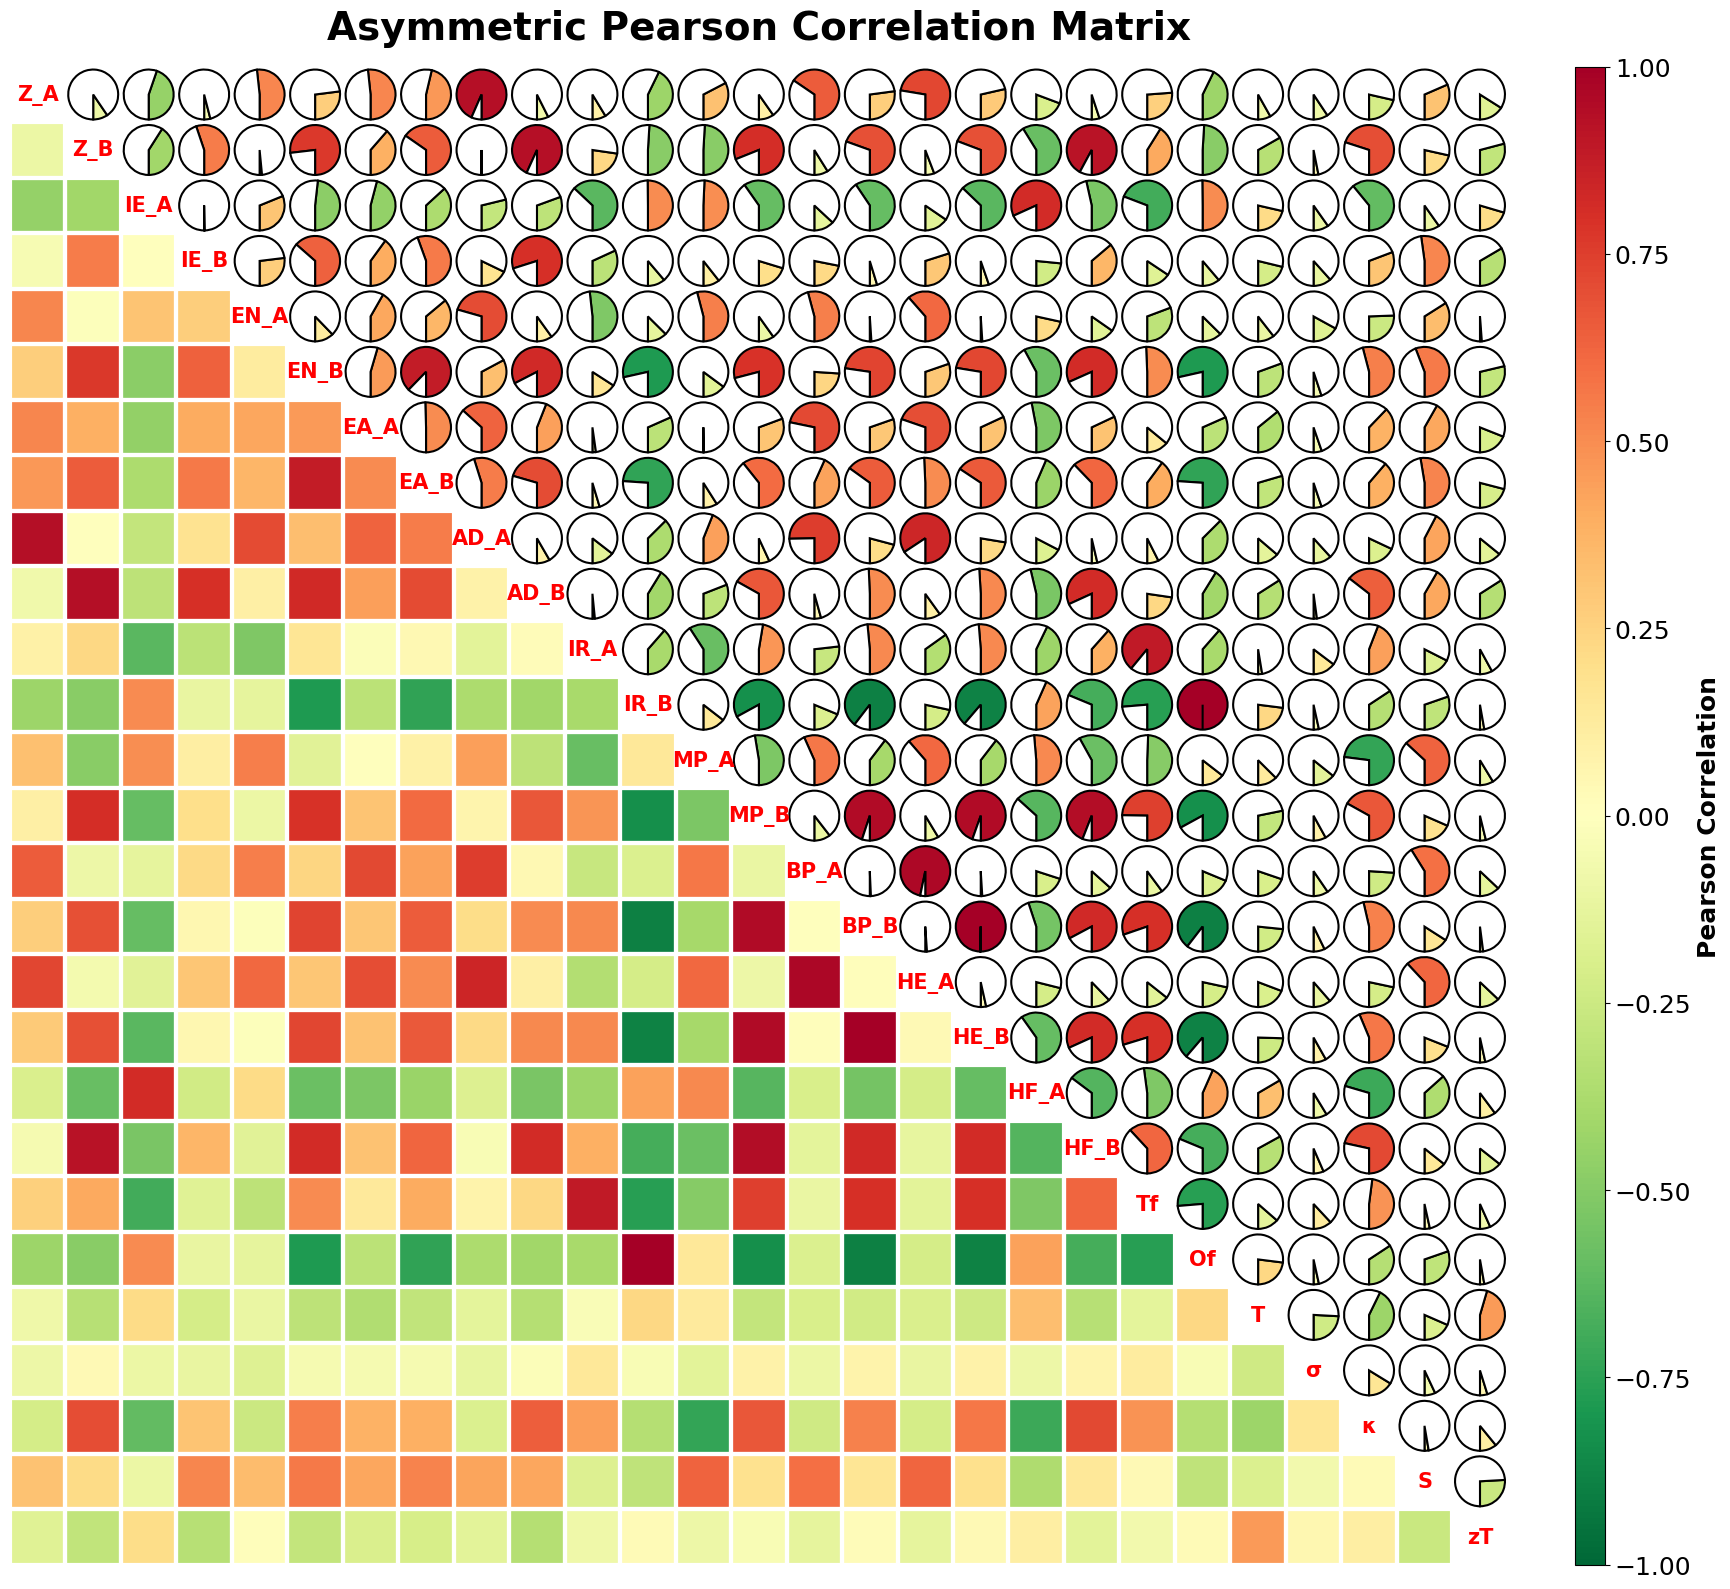

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches
from scipy.stats import pearsonr

# --- Sample Data Creation (for a runnable example) ---

np.random.seed(42)
feature_cols_abbr = [
    'Z_A', 'Z_B', 'IE_A', 'IE_B', 'EN_A', 'EN_B', 'EA_A',
    'EA_B', 'AD_A', 'AD_B', 'IR_A', 'IR_B', 'MP_A', 'MP_B', 'BP_A', 'BP_B',
    'HE_A', 'HE_B', 'HF_A', 'HF_B',  'Tf', 'Of', 'T'
]
target_cols_abbr = ['σ','κ','S','zT']
all_cols = feature_cols_abbr + target_cols_abbr
df=pd.read_csv('final_data.csv')
# --- 1. Calculate Correlation and P-value Matrices ---
corr = df[all_cols].corr(method="pearson")

def safe_pearsonr(x, y):
    # This function handles cases with no variance to avoid errors
    if np.unique(x[~np.isnan(x)]).size < 2 or np.unique(y[~np.isnan(y)]).size < 2:
        return 1.0  # Return a p-value of 1.0 (not significant)
    return pearsonr(x, y)[1]

p_values = df[all_cols].corr(method=lambda a, b: safe_pearsonr(a, b)) - np.eye(*corr.shape)

# --- 2. Set up Plot ---
fig, ax = plt.subplots(figsize=(18, 16))
# CORRECTED: Use plt.get_cmap() to properly load the colormap
cmap = plt.get_cmap('RdYlGn_r')

# --- 3. Lower triangle heatmap ---
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_display = corr.where(~mask)
# Use extent to fix the half-box issue
im = ax.imshow(corr_display, cmap=cmap, vmin=-1, vmax=1,
               extent=[-0.5, corr.shape[1]-0.5, corr.shape[0]-0.5, -0.5])


# Add a white border for EVERY cell in the lower triangle
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i > j:
            ax.add_patch(patches.Rectangle(
                (j - 0.5, i - 0.5), 1, 1,
                fill=False, edgecolor='white', lw=3
            ))

# --- 4. Upper triangle pie charts & Diagonal Labels ---
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i < j: # Upper triangle
            val = corr.iloc[i, j]
            if pd.isna(val): continue
            
            frac = abs(val)
            frac = max(0, min(frac, 1)) # Clamp to [0,1]
            color = cmap((val + 1) / 2)
            r = 0.45  # fixed radius

            ax.pie(
                [frac, 1-frac],
                colors=[color, "white"],
                radius=r,
                center=(j, i),
                startangle=90,
                counterclock=False,
                wedgeprops=dict(width=r, edgecolor='black', linewidth=1.5)
            )

        elif i == j: # Diagonal
            ax.add_patch(patches.Rectangle(
                (j - 0.5, i - 0.5), 1, 1,
                facecolor="white", edgecolor="none"
            ))
            ax.text(j, i, corr.columns[i],
                    ha="center", va="center",
                    fontsize=15, weight="bold", color="red")

# --- 5. Cosmetics ---
# Remove the outer x and y axis labels and ticks to prevent overlap
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(length=0)

# Set axis limits to ensure the full plot is visible
ax.set_xlim(-0.5, len(corr.columns) - 0.5)
ax.set_ylim(len(corr.columns) - 0.5, -0.5)


cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.04, aspect=50)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Pearson Correlation", weight="bold", size=18)

ax.set_title("Asymmetric Pearson Correlation Matrix", fontsize=28, weight="bold", pad=20)
for spine in ax.spines.values():
    spine.set_visible(False) # Hides the outer box/frame

plt.tight_layout()
plt.show()


⚠️ Failed to load Aptos font, falling back to sans-serif: [Errno 2] No such file or directory: 'aptos.ttf'

🔍 --- CORRELATION ANALYSIS STARTED ---
❌ Found 9 features to remove (Threshold > 0.85):
--------------------------------------------------
   • REMOVING 'EA_B'
     Reason: Highly correlated with 'EN_B' (Corr: 0.877)
   • REMOVING 'AD_A'
     Reason: Highly correlated with 'Z_A' (Corr: 0.934)
   • REMOVING 'AD_B'
     Reason: Highly correlated with 'Z_B' (Corr: 0.932)
   • REMOVING 'BP_B'
     Reason: Highly correlated with 'IR_B' (Corr: 0.896)
   • REMOVING 'HE_A'
     Reason: Highly correlated with 'BP_A' (Corr: 0.967)
   • REMOVING 'HE_B'
     Reason: Highly correlated with 'IR_B' (Corr: 0.887)
   • REMOVING 'HF_B'
     Reason: Highly correlated with 'Z_B' (Corr: 0.921)
   • REMOVING 'Tf'
     Reason: Highly correlated with 'IR_A' (Corr: 0.890)
   • REMOVING 'Of'
     Reason: Highly correlated with 'IR_B' (Corr: 1.000)
--------------------------------------------------
✅ Final

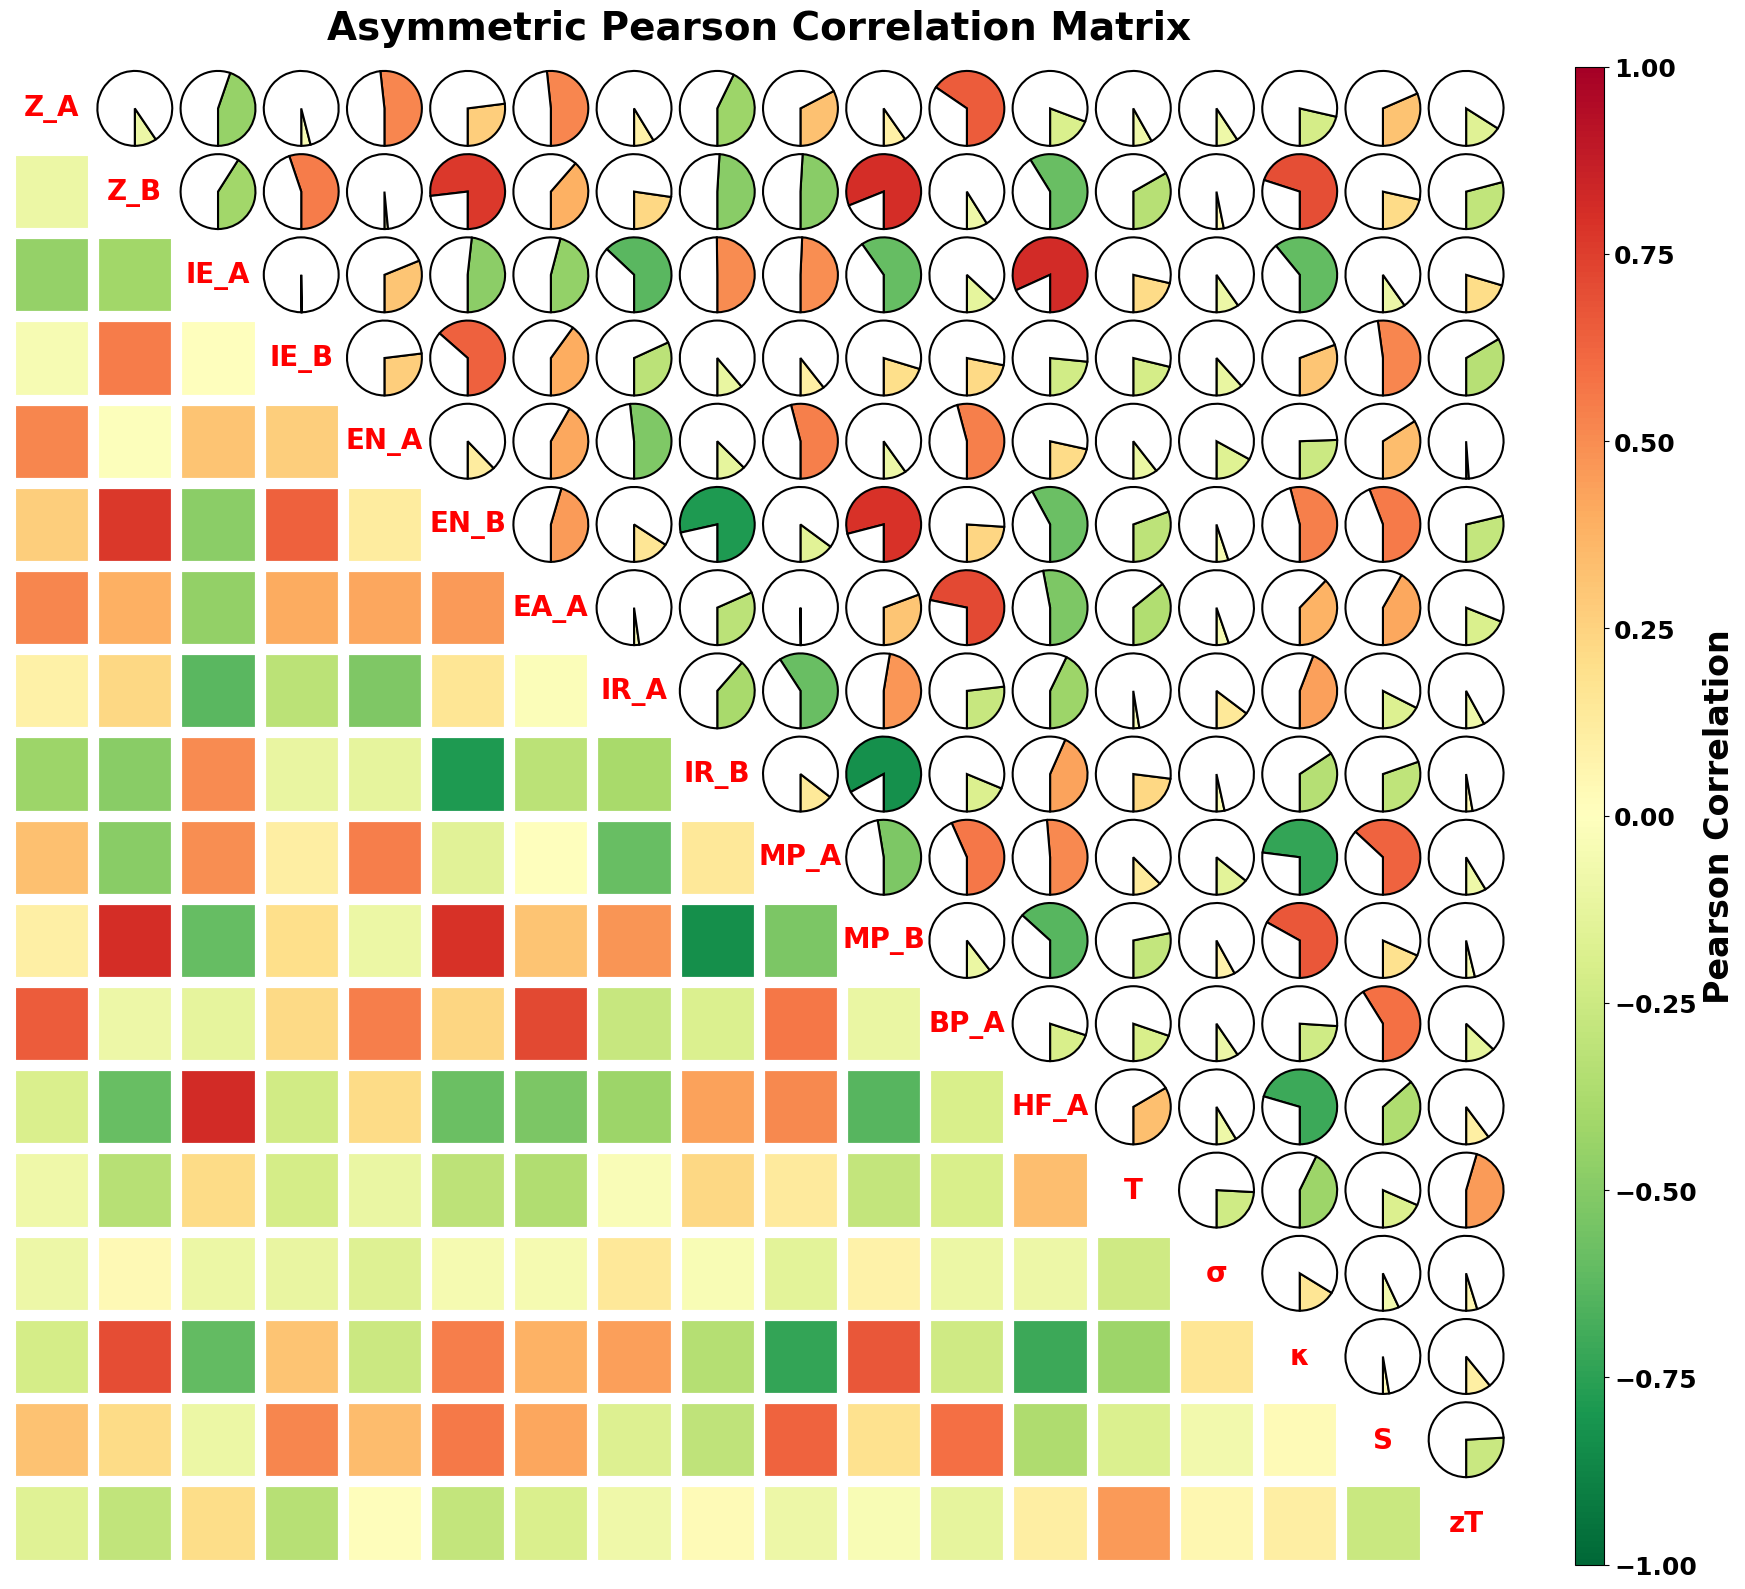

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches
from scipy.stats import pearsonr
import matplotlib.font_manager as fm

# --- Font Configuration ---
aptos_path = "aptos.ttf"  # Ensure 'aptos.ttf' is in the same directory
try:
    fm.fontManager.addfont(aptos_path)
    aptos_font_prop = fm.FontProperties(fname=aptos_path)
    plt.rcParams['font.family'] = aptos_font_prop.get_name()
    print(f"✅ Successfully set font to '{aptos_font_prop.get_name()}'")
except Exception as e:
    print(f"⚠️ Failed to load Aptos font, falling back to sans-serif: {e}")
    plt.rcParams["font.family"] = "sans-serif"

# Set global font weight to bold for consistency
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'


# --- Data Loading & Column Definitions ---
feature_cols_abbr = [
    'Z_A', 'Z_B', 'IE_A', 'IE_B', 'EN_A', 'EN_B', 'EA_A',
    'EA_B', 'AD_A', 'AD_B', 'IR_A', 'IR_B', 'MP_A', 'MP_B', 'BP_A', 'BP_B',
    'HE_A', 'HE_B', 'HF_A', 'HF_B',  'Tf', 'Of', 'T'
]
target_cols_abbr = ['σ','κ','S','zT']

# Load data (Ensure 'final_data.csv' exists)
try:
    df_original = pd.read_csv('final_data.csv')
except FileNotFoundError:
    # Create dummy data if file is missing (For testing purposes only)
    print("⚠️ 'final_data.csv' not found. Creating dummy data for demonstration...")
    data = {col: np.random.rand(50) for col in feature_cols_abbr + target_cols_abbr}
    # Force a high correlation for demo
    data['BP_A'] = data['MP_A'] * 0.95 + np.random.normal(0, 0.01, 50) 
    df_original = pd.DataFrame(data)

all_cols = feature_cols_abbr + target_cols_abbr
df = df_original[all_cols].copy()


# --- UPDATED FUNCTION: Remove Highly Correlated Features with Detailed Report ---
def remove_highly_correlated_features(df, feature_columns, threshold=0.85):
    """
    Identifies and removes highly correlated features, printing exactly why.
    """
    print("\n🔍 --- CORRELATION ANALYSIS STARTED ---")
    corr_matrix = df[feature_columns].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identify columns to drop
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    if len(to_drop) > 0:
        print(f"❌ Found {len(to_drop)} features to remove (Threshold > {threshold}):")
        print("-" * 50)
        for feat in to_drop:
            # Find the feature that caused this removal (the one it correlates with)
            # We look at the 'upper' matrix to find the value > threshold
            correlated_partners = upper.index[upper[feat] > threshold].tolist()
            
            # Get the exact correlation value for the first partner
            val = upper.loc[correlated_partners[0], feat]
            
            print(f"   • REMOVING '{feat}'")
            print(f"     Reason: Highly correlated with '{correlated_partners[0]}' (Corr: {val:.3f})")
        print("-" * 50)
    else:
        print("✅ No highly correlated features found. Keeping all.")

    retained_features = [col for col in feature_columns if col not in to_drop]
    print(f"✅ Final Retained Features: {len(retained_features)} (out of {len(feature_columns)})")
    print("-" * 50 + "\n")
    
    return retained_features

# Run the function
retained_features_abbr = remove_highly_correlated_features(df, feature_cols_abbr)

# Create filtered dataframe
final_cols_abbr = retained_features_abbr + target_cols_abbr
df_filtered = df[final_cols_abbr]


# --- 1. Calculate Correlation Matrix on FILTERED data ---
corr = df_filtered.corr(method="pearson")


# --- 2. Set up Plot ---
fig, ax = plt.subplots(figsize=(18, 16))
cmap = plt.get_cmap('RdYlGn_r')

# --- 3. Lower triangle heatmap ---
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_display = corr.where(~mask)
im = ax.imshow(corr_display, cmap=cmap, vmin=-1, vmax=1,
               extent=[-0.5, corr.shape[1]-0.5, corr.shape[0]-0.5, -0.5])

# Add a white border for EVERY cell in the lower triangle
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i > j:
            ax.add_patch(patches.Rectangle(
                (j - 0.5, i - 0.5), 1, 1,
                fill=False, edgecolor='white', lw=8
            ))

# --- 4. Upper triangle pie charts & Diagonal Labels ---
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i < j: # Upper triangle
            val = corr.iloc[i, j]
            if pd.isna(val): continue
            
            frac = abs(val)
            frac = max(0, min(frac, 1))
            color = cmap((val + 1) / 2)
            r = 0.45

            ax.pie(
                [frac, 1-frac],
                colors=[color, "white"],
                radius=r,
                center=(j, i),
                startangle=90,
                counterclock=False,
                wedgeprops=dict(width=r, edgecolor='black', linewidth=1.5)
            )

        elif i == j: # Diagonal
            ax.add_patch(patches.Rectangle(
                (j - 0.5, i - 0.5), 1, 1,
                facecolor="white", edgecolor="none"
            ))
            ax.text(j, i, corr.columns[i],
                    ha="center", va="center",
                    fontsize=20, color="red",
                    weight="bold")

# --- 5. Cosmetics ---
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(length=0)

ax.set_xlim(-0.5, len(corr.columns) - 0.5)
ax.set_ylim(len(corr.columns) - 0.5, -0.5)

cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.04, aspect=50)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Pearson Correlation", size=24)

ax.set_title("Asymmetric Pearson Correlation Matrix", fontsize=28, pad=20)
for spine in ax.spines.values():
    spine.set_visible(False)

# --- 6. Save Figure ---
output_filename = 'Figures/correlation_matrix.tif'
plt.tight_layout()
plt.savefig(output_filename, dpi=300, transparent=True, bbox_inches='tight', format='tiff')
print(f"✅ Plot saved successfully as '{output_filename}'")

plt.show() # Show must be called after saving to avoid blank file
plt.close(fig)

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches
from matplotlib import colors
import matplotlib.font_manager as fm

# --- Font Configuration ---
# Attempt to load the specific Aptos font file.
# If it fails, fall back to the default sans-serif font.
aptos_path = "aptos.ttf"  # Ensure 'aptos.ttf' is in the same directory as the script
try:
    fm.fontManager.addfont(aptos_path)
    aptos_font_prop = fm.FontProperties(fname=aptos_path)
    plt.rcParams['font.family'] = aptos_font_prop.get_name()
    print(f"✅ Successfully set font to '{aptos_font_prop.get_name()}'")
except Exception as e:
    print(f"⚠️ Failed to load Aptos font, falling back to sans-serif: {e}")
    plt.rcParams["font.family"] = "sans-serif"

# Set global font weight to bold for consistency
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'


# --- 1. Data for the Periodic Table Layout ---
elements_data = [
    {'symbol': 'H', 'group': 1, 'period': 1}, {'symbol': 'He', 'group': 18, 'period': 1},
    {'symbol': 'Li', 'group': 1, 'period': 2}, {'symbol': 'Be', 'group': 2, 'period': 2},
    {'symbol': 'B', 'group': 13, 'period': 2}, {'symbol': 'C', 'group': 14, 'period': 2},
    {'symbol': 'N', 'group': 15, 'period': 2}, {'symbol': 'O', 'group': 16, 'period': 2},
    {'symbol': 'F', 'group': 17, 'period': 2}, {'symbol': 'Ne', 'group': 18, 'period': 2},
    {'symbol': 'Na', 'group': 1, 'period': 3}, {'symbol': 'Mg', 'group': 2, 'period': 3},
    {'symbol': 'Al', 'group': 13, 'period': 3}, {'symbol': 'Si', 'group': 14, 'period': 3},
    {'symbol': 'P', 'group': 15, 'period': 3}, {'symbol': 'S', 'group': 16, 'period': 3},
    {'symbol': 'Cl', 'group': 17, 'period': 3}, {'symbol': 'Ar', 'group': 18, 'period': 3},
    {'symbol': 'K', 'group': 1, 'period': 4}, {'symbol': 'Ca', 'group': 2, 'period': 4},
    {'symbol': 'Sc', 'group': 3, 'period': 4}, {'symbol': 'Ti', 'group': 4, 'period': 4},
    {'symbol': 'V', 'group': 5, 'period': 4}, {'symbol': 'Cr', 'group': 6, 'period': 4},
    {'symbol': 'Mn', 'group': 7, 'period': 4}, {'symbol': 'Fe', 'group': 8, 'period': 4},
    {'symbol': 'Co', 'group': 9, 'period': 4}, {'symbol': 'Ni', 'group': 10, 'period': 4},
    {'symbol': 'Cu', 'group': 11, 'period': 4}, {'symbol': 'Zn', 'group': 12, 'period': 4},
    {'symbol': 'Ga', 'group': 13, 'period': 4}, {'symbol': 'Ge', 'group': 14, 'period': 4},
    {'symbol': 'As', 'group': 15, 'period': 4}, {'symbol': 'Se', 'group': 16, 'period': 4},
    {'symbol': 'Br', 'group': 17, 'period': 4}, {'symbol': 'Kr', 'group': 18, 'period': 4},
    {'symbol': 'Rb', 'group': 1, 'period': 5}, {'symbol': 'Sr', 'group': 2, 'period': 5},
    {'symbol': 'Y', 'group': 3, 'period': 5}, {'symbol': 'Zr', 'group': 4, 'period': 5},
    {'symbol': 'Nb', 'group': 5, 'period': 5}, {'symbol': 'Mo', 'group': 6, 'period': 5},
    {'symbol': 'Tc', 'group': 7, 'period': 5}, {'symbol': 'Ru', 'group': 8, 'period': 5},
    {'symbol': 'Rh', 'group': 9, 'period': 5}, {'symbol': 'Pd', 'group': 10, 'period': 5},
    {'symbol': 'Ag', 'group': 11, 'period': 5}, {'symbol': 'Cd', 'group': 12, 'period': 5},
    {'symbol': 'In', 'group': 13, 'period': 5}, {'symbol': 'Sn', 'group': 14, 'period': 5},
    {'symbol': 'Sb', 'group': 15, 'period': 5}, {'symbol': 'Te', 'group': 16, 'period': 5},
    {'symbol': 'I', 'group': 17, 'period': 5}, {'symbol': 'Xe', 'group': 18, 'period': 5},
    {'symbol': 'Cs', 'group': 1, 'period': 6}, {'symbol': 'Ba', 'group': 2, 'period': 6},
    {'symbol': 'La', 'group': 3, 'period': 8.5}, {'symbol': 'Ce', 'group': 4, 'period': 8.5},
    {'symbol': 'Pr', 'group': 5, 'period': 8.5}, {'symbol': 'Nd', 'group': 6, 'period': 8.5},
    {'symbol': 'Pm', 'group': 7, 'period': 8.5}, {'symbol': 'Sm', 'group': 8, 'period': 8.5},
    {'symbol': 'Eu', 'group': 9, 'period': 8.5}, {'symbol': 'Gd', 'group': 10, 'period': 8.5},
    {'symbol': 'Tb', 'group': 11, 'period': 8.5}, {'symbol': 'Dy', 'group': 12, 'period': 8.5},
    {'symbol': 'Ho', 'group': 13, 'period': 8.5}, {'symbol': 'Er', 'group': 14, 'period': 8.5},
    {'symbol': 'Tm', 'group': 15, 'period': 8.5}, {'symbol': 'Yb', 'group': 16, 'period': 8.5},
    {'symbol': 'Lu', 'group': 17, 'period': 8.5}, {'symbol': 'Hf', 'group': 4, 'period': 6},
    {'symbol': 'Ta', 'group': 5, 'period': 6}, {'symbol': 'W', 'group': 6, 'period': 6},
    {'symbol': 'Re', 'group': 7, 'period': 6}, {'symbol': 'Os', 'group': 8, 'period': 6},
    {'symbol': 'Ir', 'group': 9, 'period': 6}, {'symbol': 'Pt', 'group': 10, 'period': 6},
    {'symbol': 'Au', 'group': 11, 'period': 6}, {'symbol': 'Hg', 'group': 12, 'period': 6},
    {'symbol': 'Tl', 'group': 13, 'period': 6}, {'symbol': 'Pb', 'group': 14, 'period': 6},
    {'symbol': 'Bi', 'group': 15, 'period': 6}, {'symbol': 'Po', 'group': 16, 'period': 6},
    {'symbol': 'At', 'group': 17, 'period': 6}, {'symbol': 'Rn', 'group': 18, 'period': 6},
    {'symbol': 'Fr', 'group': 1, 'period': 7}, {'symbol': 'Ra', 'group': 2, 'period': 7},
    {'symbol': 'Ac', 'group': 3, 'period': 9.5}, {'symbol': 'Th', 'group': 4, 'period': 9.5},
    {'symbol': 'Pa', 'group': 5, 'period': 9.5}, {'symbol': 'U', 'group': 6, 'period': 9.5},
    {'symbol': 'Np', 'group': 7, 'period': 9.5}, {'symbol': 'Pu', 'group': 8, 'period': 9.5},
    {'symbol': 'Am', 'group': 9, 'period': 9.5}, {'symbol': 'Cm', 'group': 10, 'period': 9.5},
    {'symbol': 'Bk', 'group': 11, 'period': 9.5}, {'symbol': 'Cf', 'group': 12, 'period': 9.5},
    {'symbol': 'Es', 'group': 13, 'period': 9.5}, {'symbol': 'Fm', 'group': 14, 'period': 9.5},
    {'symbol': 'Md', 'group': 15, 'period': 9.5}, {'symbol': 'No', 'group': 16, 'period': 9.5},
    {'symbol': 'Lr', 'group': 17, 'period': 9.5}, {'symbol': 'Rf', 'group': 4, 'period': 7},
    {'symbol': 'Db', 'group': 5, 'period': 7}, {'symbol': 'Sg', 'group': 6, 'period': 7},
    {'symbol': 'Bh', 'group': 7, 'period': 7}, {'symbol': 'Hs', 'group': 8, 'period': 7},
    {'symbol': 'Mt', 'group': 9, 'period': 7}, {'symbol': 'Ds', 'group': 10, 'period': 7},
    {'symbol': 'Rg', 'group': 11, 'period': 7}, {'symbol': 'Cn', 'group': 12, 'period': 7},
    {'symbol': 'Nh', 'group': 13, 'period': 7}, {'symbol': 'Fl', 'group': 14, 'period': 7},
    {'symbol': 'Mc', 'group': 15, 'period': 7}, {'symbol': 'Lv', 'group': 16, 'period': 7},
    {'symbol': 'Ts', 'group': 17, 'period': 7}, {'symbol': 'Og', 'group': 18, 'period': 7},
]

def plot_ab_site_heatmap(a_site_frequencies, b_site_frequencies, x_site_frequencies, title="A, B, and X-site Element Occurrences"):
    """
    Plots a periodic table showing A-site, B-site, and X-site frequencies.
    A/B sites are split diagonally. X-sites are fully colored.
    """
    fig, ax = plt.subplots(figsize=(22, 12))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Combine all frequencies for a global color scale
    all_freqs = list(a_site_frequencies.values()) + list(b_site_frequencies.values()) + list(x_site_frequencies.values())
    if not all_freqs:
        print("No frequency data to plot.")
        return
        
    f_max = max(all_freqs)
    f_min = 1
    
    norm = colors.Normalize(vmin=f_min, vmax=f_max)
    colormap = plt.get_cmap('gist_rainbow')

    for element in elements_data:
        x, y = element['group'] - 0.5, 10 - element['period']
        symbol = element['symbol']

        # Special handling for X-site elements (e.g., Oxygen)
        if symbol in x_site_frequencies:
            freq_x = x_site_frequencies.get(symbol, 0)
            if freq_x > 0:
                ax.add_patch(patches.Rectangle(
                    (x - 0.5, y - 0.5), 1, 1, 
                    facecolor=colormap(norm(freq_x)), 
                    zorder=1
                ))
        else:
            # Standard handling for A and B sites
            freq_a = a_site_frequencies.get(symbol, 0)
            freq_b = b_site_frequencies.get(symbol, 0)
            
            a_vertices = np.array([[x - 0.5, y + 0.5], [x + 0.5, y + 0.5], [x - 0.5, y - 0.5]])
            b_vertices = np.array([[x + 0.5, y - 0.5], [x - 0.5, y - 0.5], [x + 0.5, y + 0.5]])

            if freq_a > 0:
                ax.add_patch(patches.Polygon(a_vertices, facecolor=colormap(norm(freq_a)), zorder=1))
            
            if freq_b > 0:
                ax.add_patch(patches.Polygon(b_vertices, facecolor=colormap(norm(freq_b)), zorder=1))
        
        # Draw the border for every cell on top
        ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1, facecolor='none', edgecolor='black', lw=4, zorder=2))
            
        # Add element symbol text (no need for weight='bold' due to global rcParams)
        ax.text(x, y, symbol, ha='center', va='center', fontsize=28, color='black', zorder=5)

    # --- Plot Cosmetics ---
    ax.set_xlim(0, 19)
    ax.set_ylim(0, 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=32, pad=25)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # --- Add Colorbar ---
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Element Frequency", size=20)
    cbar.ax.tick_params(labelsize=16)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(2)

    # --- Add Custom Legend for A/B sites ---
    legend_ax = fig.add_axes([0.40, 0.70, 0.1, 0.1])
    legend_ax.set_xlim(0, 1)
    legend_ax.set_ylim(0, 1)
    legend_ax.set_aspect('equal')
    legend_ax.add_patch(patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', lw=4))
    legend_ax.plot([0, 1], [0, 1], color='black') # The diagonal line
    legend_ax.text(0.25, 0.75, 'A', ha='center', va='center', fontsize=28)
    legend_ax.text(0.75, 0.25, 'B', ha='center', va='center', fontsize=28)
    legend_ax.axis('off')
    
    # --- Save the Figure ---
    output_filename = 'Figures/periodic_table_heatmap.tif'
    plt.savefig(
        output_filename, 
        dpi=300, 
        transparent=True, 
        bbox_inches='tight', 
        pad_inches=0.1
    )
    print(f"Plot saved as '{output_filename}'")
    plt.close(fig) # Close the figure to free up memory

# --- EXAMPLE USAGE ---
if __name__ == '__main__':
    a_site_frequencies = {
        'Ca': 63, 'Sr': 40, 'La': 25, 'Ba': 22, 'Sm': 10, 'Yb': 9, 'Y': 8, 'Nd': 7,
        'Pr': 6, 'Gd': 5, 'Eu': 4, 'Er': 4, 'Pb': 3, 'Dy': 3, 'Ce': 2, 'K': 1,
        'Ho': 1, 'Na': 1, 'Bi': 1, 'Cu': 1, 'In': 1, 'Sb': 1
    }
    b_site_frequencies = {
        'Mn': 43, 'Ti': 27, 'Co': 24, 'Fe': 19, 'Nb': 12, 'Mo': 11, 'W': 7, 'Ni': 6,
        'Ru': 6, 'Rh': 5, 'Zr': 4, 'Sn': 1, 'Ir': 1, 'Ta': 1, 'Hf': 1, 'Cr': 1
    }
    x_site_frequencies = {
        'O': 110
    }
    
    plot_ab_site_heatmap(
        a_site_frequencies=a_site_frequencies, 
        b_site_frequencies=b_site_frequencies,
        x_site_frequencies=x_site_frequencies
    )

plt.show()

⚠️ Failed to load Aptos font, falling back to sans-serif: [Errno 2] No such file or directory: 'aptos.ttf'
Plot saved as 'Figures/periodic_table_heatmap.tif'
